# Chapter 1: Sensor Data Smoothing and Filtering  

Most sensor data is affected to some extent by noise. In this assignment, you will see a few examples of noisy signals and apply several techniques to remove noise from them. These techniques are also described in the corresponding chapter.

In [133]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import butter, freqz, filtfilt, firwin, iirnotch, lfilter
matplotlib.style.use('ggplot')

# enable zooming into graphs
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (10, 5) 

## Example 1: Noisy Accelerometer Signals

In the first example, we will look at removing noise from an accelerometer signal captured from a phone in the pocket while an individual is walking. There are many sources of noise in accelerometer signals from a smartphone or smartwatch/fitness band. The main noise sources are because the phone is moving around in your pocket or bag while walking, or a wristband moving a little on your wrist as you move it. 

Even if you are stationary, there are micro-tremors of the hand or body that are picked up by the accelerometer. In some cases, there are also external noise sources. For example, if you are on an elevator, some of the vibrations of the elevator are transmitted to your phone and captured by it. Similarly, when a phone is placed on a desk, the vibrations of the HVAC system are often transmitted to the phone. This noise needs to be removed before you can further process the signal.

In [134]:
log_filename = 'data/Accel-Smoothing/accelerometer.csv'

raw_data = np.loadtxt(log_filename, delimiter=',', unpack=True, skiprows=0)
(timestamps, x_data, y_data, z_data) = raw_data
 
signal = np.sqrt(x_data**2 + y_data**2 + z_data**2)

# start timestamps from zero (assume timestamps are in milliseconds)
c = timestamps[0]
timestamps = (timestamps - c)

signal = signal[1000:2000]
timestamps = timestamps[1000:2000]

## Time-domain Noise Removal: Moving Average Filter

Many sources of noise tend to be random in nature. Informally, this means that the noise has roughly equal amounts of positive and negative changes, and there is no pattern in the noise over time. 

In this case, noise can be reduced by weighted averaging the values. For example, take the case where you are writing an algorithm to determine the rotation of the screen of the mobile phone. Since you have noise due to small hand movements (if you are holding the phone), you may perform a weighted average of every 10 samples readings and use the smoothed signal in the application to determine whether the screen has rotated. In this way, the noise in the acceleration signal is reduced. 

We are going to try to smooth the data with a moving average filter, which is a simple filter where the weights are all one. The function "convolve" takes a window corresponding to the moving average weights and essentially multiplies it with the data. The result is the smoothed signal. There are two key parameters to think about when designing an averaging filter. The first is the window size and the second is the set of weights.  

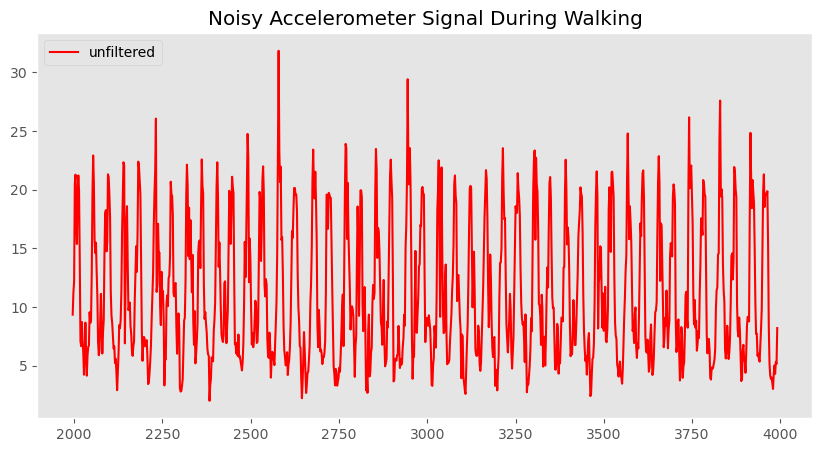

In [135]:
# plot accelerometer data
plt.figure(figsize=(10,5))
plt.plot(timestamps, signal, 'r-',label="unfiltered")
plt.title("Noisy Accelerometer Signal During Walking")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

#### Parameters: Window size and weights
There are two key parameters to think about when designing an averaging filter. The first is the window size and the second is the set of weights.  
* <b>Window size</b>: The window size determines how much smoothing is performed on the signal. In the example below, we are going to replace each sample by the average of a window of ten samples around it. We could have averaged more nearby points to smooth even more aggressively. As you increase the smoothing window, the signal will look cleaner and more visually pleasing, but beware of using too large a window since you will smooth out the important characteristics of the signal (for example, steps if you want to do step detection). Try increasing window size and see the effect.

* <b>Weights</b>: Different averaging filters give different amounts of weight to the set of values that are aveeraged. The moving average filter gives equal weight to the values averaged whereas exponentially weighted moving average filter gives exponentially decreasing weights as the observation get older (i.e. recent observations are given relatively more weight than the older observations).

<b>ASSIGNMENT:</b> Plot two graphs, one for a simple moving average filter (equal weights) and exponentially weighted moving average filter (exponentially decreasing weights. An example of the figure for moving average is shown below. You need to generate a figure similar to this and also plot the exponentially weighted version in a separate plot.

<img src="figures/chapter1-average.png" width=700>

In [136]:
# FILL IN CODE: Apply moving average filter with window size 10

# Define moving average parameters
window_size = 10
pad_width = window_size // 2

# Apply moving average filter
padded_data = np.pad(signal, pad_width, mode='edge')
weights = np.ones(window_size) / window_size
moving_averages = np.convolve(padded_data, weights, mode='valid')

# Adjust timestamps based on the original length of the signal
timestamps_adjusted = timestamps[pad_width:len(signal) + pad_width]

C:\Users\Default.DESKTOP-8HD5MR5\AppData\Local\Temp\ipykernel_27188\1309670808.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(timestamps_adjusted, moving_averages[:len(timestamps_adjusted)], 'r-', label="filtered", color="green")


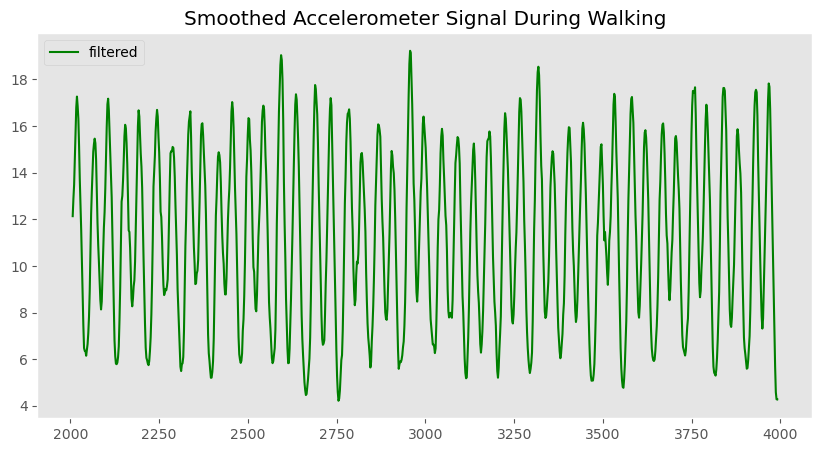

In [137]:
# FILL IN CODE: Plot filtered signal

# Plot results
plt.figure(figsize=(10, 5))
#plt.plot(timestamps, signal, 'r-',label="unfiltered", color="red")
plt.plot(timestamps_adjusted, moving_averages[:len(timestamps_adjusted)], 'r-', label="filtered", color="green")
plt.title("Smoothed Accelerometer Signal During Walking")
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [138]:
# FILL IN CODE: Apply exponentially weighted average filter with window size 10

# Define moving average parameters
window_size = 10
pad_width = window_size // 2

# Apply exponentially weighted moving average filter
alpha = 0.2  # Smoothing factor
base = 0.5  # Base for exponential weights
weights = np.power(base, np.arange(window_size)[::-1])
weights /= weights.sum()
padded_data = np.pad(signal, pad_width, mode='edge')
ewma_values = np.convolve(padded_data, weights, mode='valid')

# Adjust timestamps based on the original length of the signal
timestamps_adjusted = timestamps[pad_width:len(signal) + pad_width]

# Ensure both arrays have the same length
min_length = min(len(timestamps_adjusted), len(ewma_values))
timestamps_adjusted = timestamps_adjusted[:min_length]
ewma_values = ewma_values[:min_length]

C:\Users\Default.DESKTOP-8HD5MR5\AppData\Local\Temp\ipykernel_27188\193603952.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(timestamps_adjusted, ewma_values, 'r-', label="exponential filter", color="orange")


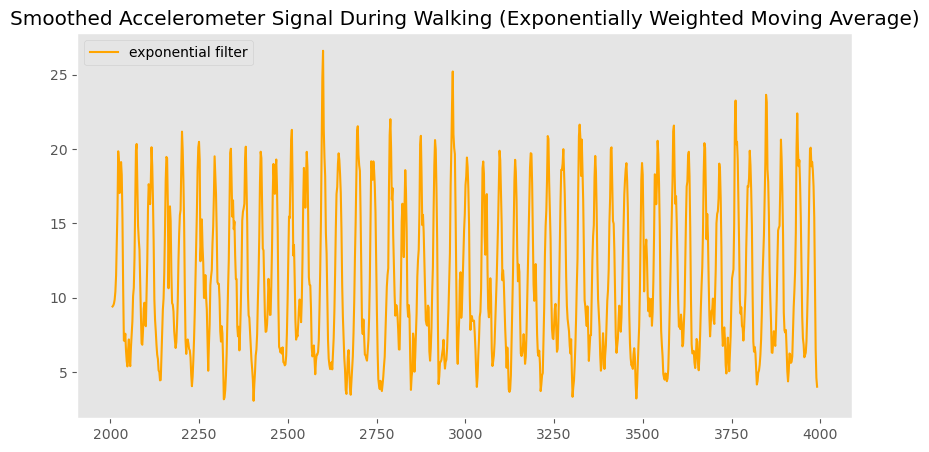

In [139]:
# FILL IN CODE: Plot filtered signal

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(timestamps_adjusted, ewma_values, 'r-', label="exponential filter", color="orange")
plt.title("Smoothed Accelerometer Signal During Walking (Exponentially Weighted Moving Average)")
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Frequency-domain Filtering: Butterworth Filter

Let us now turn to noise in the frequency domain. Frequency-domain noise can be removed by a combination of frequency filters. A low-pass filter can remove high frequency components while letting through low frequency components. A high pass filter does the reverse and lets high frequency components through while removing low frequency components. A notch filter removes a specific frequency from the signal. 

We are now going to use a filter called a 'butterworth filter' to remove noise. A Butterworth filter is a popular frequency domain 'lowpass' filter that can remove high frequency noise while only letting the low frequencies through. Since the walking signal is low frequency (only a few steps minute), this is a good approach.

<b> ASSIGNMENT:</b> You are given the code to construct the butterworth filter and apply it to the signal. Your task is to just plot the result.

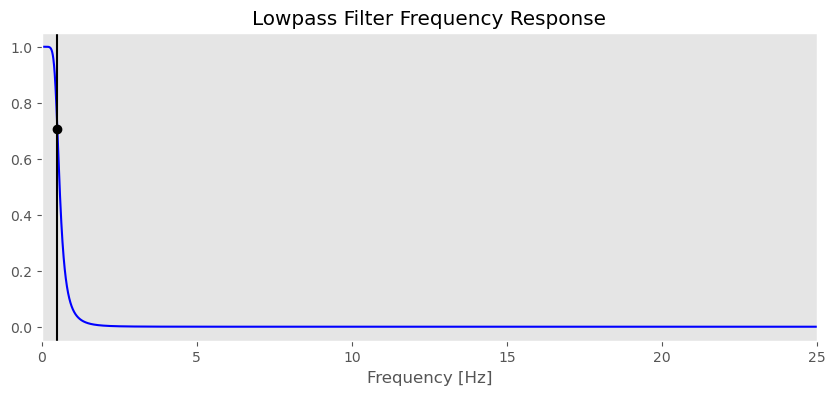

In [140]:
# Filter requirements.
order = 4
fs = 50.0  # sample rate, Hz
cutoff = 0.5  # desired cutoff frequency of the filter, Hz. MODIFY AS APPROPROATE

# Create the filter.
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='low', analog=False)

# Frequency response graph
w, h = freqz(b, a, worN=8000)
plt.figure(figsize=(10,4))

plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5 * np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5 * fs)
plt.title('Lowpass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

# Apply the butterworth filter on the signal
filtered_signal = filtfilt(b, a, signal)

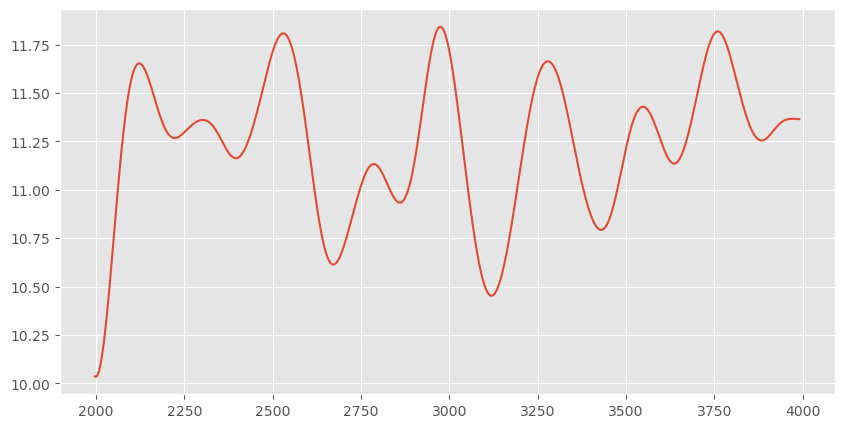

In [141]:
# Apply the butterworth filter the the signal and obtain the filtered signal 
# HINT: function `filtfilt` from the scipy.signal will be useful here
# FILL IN:  Plot both the original and filtered signals on the same graph.
# Adjust the cutoff parameter until you get the best noise removal result. EXPLAIN WHY.

# Ensure both arrays have the same length
min_length = min(len(timestamps), len(filtered_signal))
new_timestamps = timestamps[:min_length]
filtered_signal = filtered_signal[:min_length]

plt.plot(timestamps, filtered_signal)
plt.show()

#0.6 is the best cutoff because it is the average

## Example 2: Noisy ECG signals

In the second example, we will look at removing noise from an ECG trace. This signal is a Lead I ECG signal acquired at 1000 Hz, with a resolution of 12 bit. Although of good quality, it exhibits powerline noise interference, has an offset resulting from the acquisition device, and we can also observe the influence of breathing in the variability of peak amplitudes.

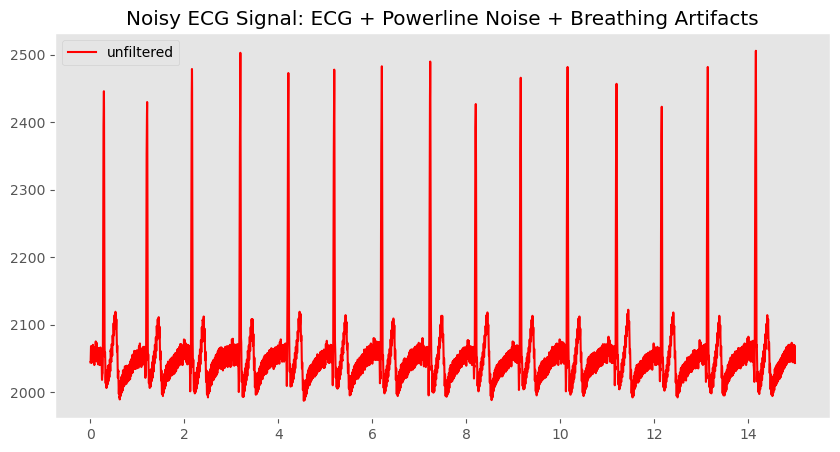

In [142]:
plt.figure()
signal = np.loadtxt('data/ECG-Filtering/ecg.txt')
sampling_rate =1000
N = len(signal) # number of samples
T = (N - 1) / sampling_rate # duration
ts = np.linspace(0, T, N, endpoint=False) # relative timestamps
plt.plot(ts, signal, 'r-',label='unfiltered')
plt.title("Noisy ECG Signal: ECG + Powerline Noise + Breathing Artifacts")
plt.legend(loc='upper left')
plt.grid()
plt.show()

### Moving Average Filter

**ASSIGNMENT:** You are going to try to smooth ECG with a simple moving average filter. As with the Accelerometer signal, try moving average filters and exponentially weighted moving average filters and plot the results.


C:\Users\Default.DESKTOP-8HD5MR5\AppData\Local\Temp\ipykernel_27188\3797160237.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(timestamps_adjusted, moving_averages[:len(timestamps_adjusted)], 'r-', label="filtered", color="green")
C:\Users\Default.DESKTOP-8HD5MR5\AppData\Local\Temp\ipykernel_27188\3797160237.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(timestamps_adjusted, ewma_values, 'r-', label="exponential filter", color="orange")


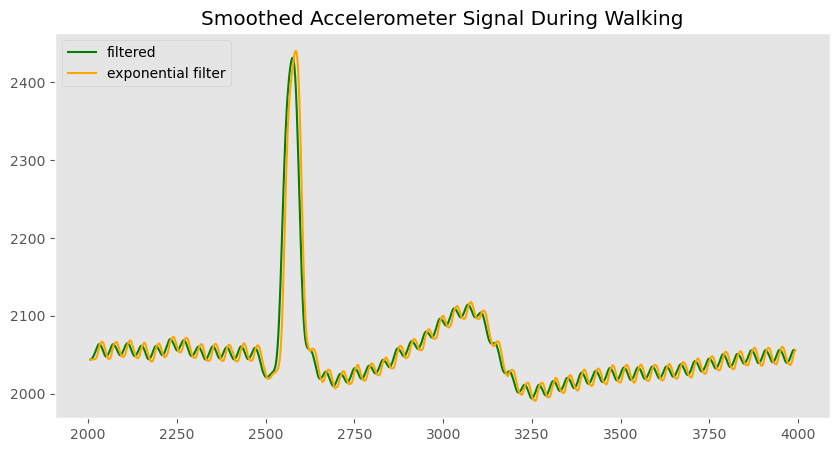

In [143]:
# FILL IN: Your code for moving average and exponential moving average goes here. Also plot these filtered signals.

# Define moving average parameters
window_size = 10
pad_width = window_size // 2

# Apply moving average filter
padded_data = np.pad(signal, pad_width, mode='edge')
weights = np.ones(window_size) / window_size
moving_averages = np.convolve(padded_data, weights, mode='valid')

# Adjust timestamps based on the original length of the signal
timestamps_adjusted = timestamps[pad_width:len(signal) + pad_width]

# Plot results
plt.figure(figsize=(10, 5))
#plt.plot(timestamps, signal, 'r-',label="unfiltered", color="red")
plt.plot(timestamps_adjusted, moving_averages[:len(timestamps_adjusted)], 'r-', label="filtered", color="green")
plt.title("Smoothed Accelerometer Signal During Walking")
plt.legend(loc='upper left')
#plt.grid()
#plt.show()


# Define moving average parameters
window_size = 10
pad_width = window_size // 2

# Apply exponentially weighted moving average filter
alpha = 0.2  # Smoothing factor
base = 0.5  # Base for exponential weights
weights = np.power(base, np.arange(window_size)[::-1])
weights /= weights.sum()
padded_data = np.pad(signal, pad_width, mode='edge')
ewma_values = np.convolve(padded_data, weights, mode='valid')

# Adjust timestamps based on the original length of the signal
timestamps_adjusted = timestamps[pad_width:len(signal) + pad_width]

# Ensure both arrays have the same length
min_length = min(len(timestamps_adjusted), len(ewma_values))
timestamps_adjusted = timestamps_adjusted[:min_length]
ewma_values = ewma_values[:min_length]

# Plot results
#plt.figure(figsize=(10, 5))
plt.plot(timestamps_adjusted, ewma_values, 'r-', label="exponential filter", color="orange")
#plt.title("Smoothed Accelerometer Signal During Walking (Exponentially Weighted Moving Average)")
plt.legend(loc='upper left')
plt.grid()
plt.show()

### Frequency-domain filtering

A classic example of how these frequency domain filters are used for noise removal is in the case of ECG filtering, so let us discuss how this works. There are three sources of noise in the ECG data shown above
* <b>Baseline Wander</b>: Baseline wander is a low-frequency component present in the ECG system which causes the signal to “wander” off from the actual ECG waveform.
* <b>Powerline Noise</b>: The frequency of alternating current in the electrical mains is typically around 50-60Hz. Since this is in the frequency range of the ECG signal that we are interested in, it appears as a significant source of noise that can disrupt any measurement that we wish to make.
* <b>High frequency Noise</b>: Various other electronic equipment in the vicinity of the ECG sensor including pacemakers, mobile phones, and other electronics can interfere with the ECG signal. These sources of noise are high frequency, and need to be removed by an appropriately selected low-pass filter.

We will use the filtering pipeline shown below (see class notes). First, we will use a band pass filter and then apply a notch filter that removes power line noise.

#### Band pass filter to remove baseline wander and high-frequency noise

We first apply a bandpass filter to remove all frequencies between two values. We have given 10-11Hz as default; you should adjust these parameters below based on your understanding of what frequencies generate most of the noise.

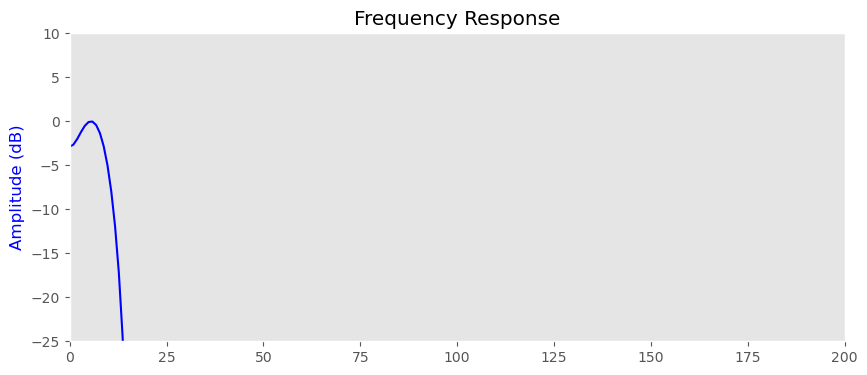

In [144]:
# remove baseline wander caused by breathing
fs = sampling_rate  # Sample frequency (Hz)
order = int(0.3 * sampling_rate)
if order % 2 == 0: order += 1

# the cutoff frequencies for the filter. MODIFY AS NEEDED.
f1, f2 = 1, 10

# remember to normalize the frequencies to nyquist.
f1 = 2. * f1 / sampling_rate
f2 = 2. * f2 / sampling_rate

a = np.array([1])
b = firwin(order,[f1, f2],pass_zero=False)

# Frequency response
w, h = freqz(b, a)
# Generate frequency axis
freq = w*fs/(2*np.pi)
# Plot
plt.figure(figsize=(10,4))
plt.plot(freq, 20*np.log10(abs(h)), color='blue')
plt.title("Frequency Response")
plt.ylabel("Amplitude (dB)", color='blue')
plt.xlim([0, 200])
plt.ylim([-25, 10])
plt.grid()
plt.show()

#### Notch filter to remove powerline noise

The next step is remove powerline noise using what is called a notch filter. The notch filtered is centered at a specific frequency and removes that frequency. This is set to 10Hz below but you need to adjust the value to the correct one.

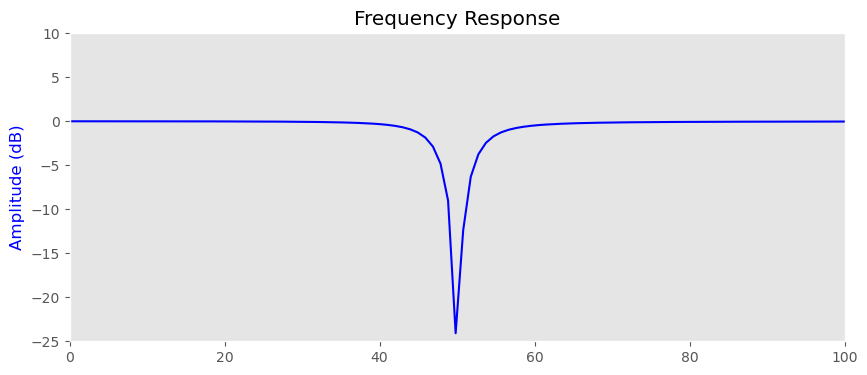

In [145]:
fs = sampling_rate  # Sample frequency (Hz)
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 8.0  # Quality factor
w0 = f0/(fs/2)  # Normalized Frequency
# Design notch filter
b, a = iirnotch(w0, Q)

# Frequency response
w, h = freqz(b, a)
# Generate frequency axis
freq = w*fs/(2*np.pi)
# Plot
plt.figure(figsize=(10,4))
plt.plot(freq, 20*np.log10(abs(h)), color='blue')
plt.title("Frequency Response")
plt.ylabel("Amplitude (dB)", color='blue')
plt.xlim([0, 100])
plt.ylim([-25, 10])
plt.grid()
plt.show()

512
512


C:\Users\Default.DESKTOP-8HD5MR5\AppData\Local\Temp\ipykernel_27188\1362520105.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(timestamps, filtered_signal, 'r-', label='Bandpass', color='blue')
C:\Users\Default.DESKTOP-8HD5MR5\AppData\Local\Temp\ipykernel_27188\1362520105.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(timestamps, filtered_signal, 'r-', label='Notchpass', color='green')


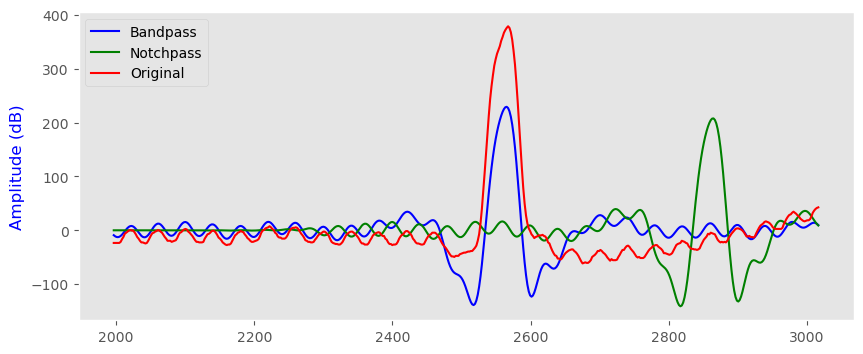

In [189]:
# FILL IN: Apply the bandpass filter to the signal
signal = signal - np.mean(signal)

#Apply bandpass
filtered_signal = np.convolve(signal, b, mode='same')

# Plot
plt.figure(figsize=(10,4))
plt.plot(timestamps, filtered_signal, 'r-', label='Bandpass', color='blue')

# FILL IN: Next apply the notch filter to the signal

#Apply notchpass
filtered_signal = lfilter(b, a, filtered_signal)

#Plot
plt.plot(timestamps, filtered_signal, 'r-', label='Notchpass', color='green')

# Plot three figures: a) Original signal b) After bandpass filter is applied and 
# c) After bandpass + notch filters are applied. 

#Original plot
plt.plot(timestamps, signal, label="Original", color='red')

# Ensure both arrays have the same length
min_length = min(len(timestamps), len(signal))
timestamps = timestamps[:min_length]
signal = signal[:min_length]
print(len(timestamps))
print(len(signal))

#Plot results
plt.legend(loc='upper left')
plt.ylabel("Amplitude (dB)", color='blue')
#plt.xlim([0, 200])
#plt.ylim([-25, 10])
plt.grid()
plt.show()